In [22]:
import os, glob, json
from pathlib import Path

import numpy as np
import pandas as pd

from skimage import io, color, filters, morphology, segmentation, measure, util
from skimage.segmentation import watershed
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage import measure

In [2]:
# Cell 1 — Find images inside data/<respective_folder>
IMG_EXTS = (".png", ".jpg", ".jpeg", ".webp", ".tif", ".tiff", ".bmp")

def find_images(root="data"):
    root = Path(root)
    paths = []
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            paths.append(p)
    return sorted(paths)

image_paths = find_images("data")
len(image_paths), image_paths[:5]

(130,
 [WindowsPath('data/generated/ComfyUI_00082_.png'),
  WindowsPath('data/generated/ComfyUI_00083_.png'),
  WindowsPath('data/generated/ComfyUI_00084_.png'),
  WindowsPath('data/generated/ComfyUI_00085_.png'),
  WindowsPath('data/generated/ComfyUI_00086_.png')])

In [3]:
# Cell 2 — Image loader (robust)
def load_rgb(path: Path):
    img = io.imread(str(path))
    # Handle grayscale or RGBA
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    elif img.shape[-1] == 4:
        img = img[..., :3]
    img = util.img_as_float32(img)  # scales to [0,1] for uint8/uint16
    return np.clip(img, 0.0, 1.0)

# quick test
test_img = load_rgb(image_paths[0])
test_img.shape, test_img.min(), test_img.max()

((512, 512, 3), np.float32(0.0), np.float32(1.0))

### Structural Segmentation

In [4]:
# Cell 3 — Multi-scale edges + watershed segmentation
def structural_segmentation(rgb,
                            sigmas=(1.0, 2.0, 4.0),
                            canny_low=0.05, canny_high=0.2,
                            close_radius=2,
                            min_region_area_px=500):
    """
    Returns: labels (H,W) int32, 0..K-1
    """
    gray = color.rgb2gray(rgb)

    # Multi-scale edge map (binary)
    edges_list = []
    for s in sigmas:
        # Smooth then edge
        sm = filters.gaussian(gray, sigma=s, preserve_range=True)
        ed = canny(sm, low_threshold=canny_low, high_threshold=canny_high)
        edges_list.append(ed)
    edges = np.logical_or.reduce(edges_list)

    # Close small gaps in edges
    if close_radius and close_radius > 0:
        se = morphology.disk(int(close_radius))
        edges = morphology.binary_closing(edges, se)

    # Distance from edges (regions are basins between edges)
    dist = ndi.distance_transform_edt(~edges)

    # Markers: local maxima of distance
    # Use h-maxima to suppress spurious markers
    h = np.percentile(dist, 90) * 0.25  # heuristic; stable enough
    maxima = morphology.h_maxima(dist, h=h)
    markers = measure.label(maxima)

    # Watershed on -dist, constrained by edges
    labels = watershed(-dist, markers, mask=np.ones_like(gray, dtype=bool))

    # Remove tiny regions by merging into nearest neighbor
    labels = relabel_and_drop_small(labels, min_region_area_px=min_region_area_px)

    return labels.astype(np.int32)

def relabel_and_drop_small(labels, min_region_area_px=500):
    """Merge tiny regions by setting them to -1 then relabeling via skimage."""
    lab = labels.copy()
    props = measure.regionprops(lab)
    small = [p.label for p in props if p.area < min_region_area_px]
    if len(small) == 0:
        return segmentation.relabel_sequential(lab)[0]

    # set small labels to 0 mask then fill by nearest non-small using dilation
    mask_small = np.isin(lab, small)
    lab2 = lab.copy()
    lab2[mask_small] = 0

    # fill zeros by nearest label (Voronoi-style) using distance transform
    nonzero = lab2 > 0
    if nonzero.any():
        _, (iy, ix) = ndi.distance_transform_edt(~nonzero, return_indices=True)
        lab2[~nonzero] = lab2[iy[~nonzero], ix[~nonzero]]

    # relabel sequentially
    lab2, _, _ = segmentation.relabel_sequential(lab2)
    return lab2

### Convert to CIELAB + compute region stats

In [5]:
def region_lab_stats(rgb, labels):
    """
    rgb: (H,W,3) in [0,1]
    labels: (H,W) int, 0..K-1
    Returns dataframe with per-region stats.
    """
    lab = color.rgb2lab(rgb)  # L*: 0..100, a*,b* roughly [-128,127]
    H, W = labels.shape
    K = labels.max() + 1

    # Flatten for fast vectorized aggregation
    lab_f = lab.reshape(-1, 3)
    lbl_f = labels.reshape(-1)

    # Area
    area = np.bincount(lbl_f, minlength=K).astype(np.int64)

    # Means
    sumL = np.bincount(lbl_f, weights=lab_f[:,0], minlength=K)
    suma = np.bincount(lbl_f, weights=lab_f[:,1], minlength=K)
    sumb = np.bincount(lbl_f, weights=lab_f[:,2], minlength=K)

    meanL = sumL / np.maximum(area, 1)
    meana = suma / np.maximum(area, 1)
    meanb = sumb / np.maximum(area, 1)

    # Variances: E[x^2] - (E[x])^2
    sumL2 = np.bincount(lbl_f, weights=lab_f[:,0]**2, minlength=K)
    suma2 = np.bincount(lbl_f, weights=lab_f[:,1]**2, minlength=K)
    sumb2 = np.bincount(lbl_f, weights=lab_f[:,2]**2, minlength=K)

    varL = (sumL2 / np.maximum(area, 1)) - meanL**2
    vara = (suma2 / np.maximum(area, 1)) - meana**2
    varb = (sumb2 / np.maximum(area, 1)) - meanb**2

    # Clip tiny negative due to floating errors
    varL = np.maximum(varL, 0)
    vara = np.maximum(vara, 0)
    varb = np.maximum(varb, 0)

    df = pd.DataFrame({
        "region_id": np.arange(K, dtype=int),
        "area_px": area,
        "area_frac": area / float(H*W),
        "mean_L": meanL,
        "mean_a": meana,
        "mean_b": meanb,
        "var_L": varL,
        "var_a": vara,
        "var_b": varb,
    })
    return df


In [6]:
idx = 0  # change this
path = image_paths[idx]
rgb = load_rgb(path)

labels = structural_segmentation(rgb, min_region_area_px=800)  # tweak if too many tiny regions
df_regions = region_lab_stats(rgb, labels)

path.name, df_regions.shape, df_regions.head()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


('ComfyUI_00082_.png',
 (9, 9),
    region_id  area_px  area_frac     mean_L     mean_a     mean_b       var_L  \
 0          0        0   0.000000   0.000000   0.000000   0.000000    0.000000   
 1          1    31498   0.120155  29.168966  20.432918  12.539210  172.728309   
 2          2    44150   0.168419  34.175027  22.122639  11.111537  230.956520   
 3          3    39000   0.148773  43.243348  64.435240  42.604683   10.178401   
 4          4     1837   0.007008  41.977828  65.302999  42.997318   10.605135   
 
        var_a      var_b  
 0   0.000000   0.000000  
 1  40.260588  19.957062  
 2  52.358909  24.815519  
 3  16.859723  12.158153  
 4  10.726727   9.216352  )

In [7]:
# Cell 6 — Batch processing
def process_image(path: Path,
                  min_region_area_px=800):
    rgb = load_rgb(path)
    labels = structural_segmentation(rgb, min_region_area_px=min_region_area_px)
    df = region_lab_stats(rgb, labels)
    df.insert(0, "image_path", str(path))
    df.insert(1, "image_name", path.name)
    df.insert(2, "n_regions", int(labels.max() + 1))
    return df

all_rows = []
for p in image_paths:
    try:
        all_rows.append(process_image(p, min_region_area_px=800))
    except Exception as e:
        print(f"[WARN] Failed: {p} -> {e}")

df_all_regions = pd.concat(all_rows, ignore_index=True)
df_all_regions.shape, df_all_regions.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges

((2056, 12),
                           image_path          image_name  n_regions  \
 0  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9   
 1  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9   
 2  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9   
 3  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9   
 4  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9   
 
    region_id  area_px  area_frac     mean_L     mean_a     mean_b       var_L  \
 0          0        0   0.000000   0.000000   0.000000   0.000000    0.000000   
 1          1    31498   0.120155  29.168966  20.432918  12.539210  172.728309   
 2          2    44150   0.168419  34.175027  22.122639  11.111537  230.956520   
 3          3    39000   0.148773  43.243348  64.435240  42.604683   10.178401   
 4          4     1837   0.007008  41.977828  65.302999  42.997318   10.605135   
 
        var_a      var_b  
 0   0.000000   0.000000  
 1  4

In [8]:
out_dir = Path("outputs_color")
out_dir.mkdir(exist_ok=True)

csv_path = out_dir / "color_region_lab_stats.csv"
df_all_regions.to_csv(csv_path, index=False)

print("Saved:", csv_path)

Saved: outputs_color\color_region_lab_stats.csv


### Adjacency + ΔL + Boundary Length

### Helper: adjacency extraction from labels

In [9]:
def adjacency_from_labels(labels: np.ndarray):
    """
    Build adjacency pairs and shared boundary length (in pixel-edges) from a label map.
    Returns:
      pairs: (M,2) array of sorted (i,j) region ids, i<j
      counts: (M,) boundary length counts (number of adjacent pixel edges)
    """
    lab = labels.astype(np.int32)
    H, W = lab.shape

    pairs = []

    # Horizontal adjacencies: (y,x) with (y,x+1)
    a = lab[:, :-1]
    b = lab[:, 1:]
    mask = a != b
    if mask.any():
        p = np.stack([a[mask], b[mask]], axis=1)
        pairs.append(p)

    # Vertical adjacencies: (y,x) with (y+1,x)
    a = lab[:-1, :]
    b = lab[1:, :]
    mask = a != b
    if mask.any():
        p = np.stack([a[mask], b[mask]], axis=1)
        pairs.append(p)

    if not pairs:
        return np.zeros((0,2), dtype=np.int32), np.zeros((0,), dtype=np.int64)

    pairs = np.vstack(pairs)

    # Sort each pair so (min,max) to canonicalize
    pairs = np.sort(pairs, axis=1)

    # Count occurrences = shared boundary length (pixel-edge count)
    # Use structured view for unique rows
    pairs_view = pairs.view([('i', pairs.dtype), ('j', pairs.dtype)])
    uniq, counts = np.unique(pairs_view, return_counts=True)

    uniq_pairs = np.stack([uniq['i'], uniq['j']], axis=1).astype(np.int32)
    counts = counts.astype(np.int64)

    return uniq_pairs, counts

#### Compute ΔL matrix for one image

In [10]:
def luminance_difference_matrix(rgb, labels):
    """
    Compute adjacency and ΔL* (based on region mean L* in Lab).
    Returns dataframe with columns:
      region_i, region_j, boundary_len_px, delta_L
    """
    # Region means in Lab
    lab = color.rgb2lab(rgb)
    H, W = labels.shape
    K = labels.max() + 1

    lab_f = lab.reshape(-1, 3)
    lbl_f = labels.reshape(-1)

    area = np.bincount(lbl_f, minlength=K).astype(np.int64)
    sumL = np.bincount(lbl_f, weights=lab_f[:,0], minlength=K)
    meanL = sumL / np.maximum(area, 1)

    # Adjacency + boundary length
    pairs, boundary_len = adjacency_from_labels(labels)

    if len(pairs) == 0:
        return pd.DataFrame(columns=["region_i","region_j","boundary_len_px","delta_L"])

    i = pairs[:,0]
    j = pairs[:,1]
    delta_L = np.abs(meanL[i] - meanL[j])

    df = pd.DataFrame({
        "region_i": i,
        "region_j": j,
        "boundary_len_px": boundary_len,
        "delta_L": delta_L
    })

    # optional: normalize boundary length by image perimeter scale
    df["boundary_len_frac"] = df["boundary_len_px"] / float((H*(W-1) + (H-1)*W))  # total possible pixel-edges
    return df

# --- Quick sanity test on one image ---
idx = 0
path = image_paths[idx]
rgb = load_rgb(path)
labels = structural_segmentation(rgb, min_region_area_px=800)

df_edges = luminance_difference_matrix(rgb, labels)
path.name, df_edges.shape, df_edges.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


('ComfyUI_00082_.png',
 (17, 5),
    region_i  region_j  boundary_len_px    delta_L  boundary_len_frac
 0         1         2               46   5.006060           0.000088
 1         1         3               34  14.074382           0.000065
 2         1         4               15  12.808862           0.000029
 3         1         5              360  14.360819           0.000688
 4         1         7               75   4.623709           0.000143)

### Add image metadata + save per-image adjacency

In [11]:
def compute_step2_for_image(path: Path, min_region_area_px=800):
    rgb = load_rgb(path)
    labels = structural_segmentation(rgb, min_region_area_px=min_region_area_px)
    df = luminance_difference_matrix(rgb, labels)
    df.insert(0, "image_path", str(path))
    df.insert(1, "image_name", path.name)
    df.insert(2, "n_regions", int(labels.max() + 1))
    return df

# Save a single example
out_dir = Path("outputs_color")
out_dir.mkdir(exist_ok=True)

example_df = compute_step2_for_image(image_paths[0], min_region_area_px=800)
example_path = out_dir / "example_luminance_adjacency.csv"
example_df.to_csv(example_path, index=False)
print("Saved:", example_path)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


Saved: outputs_color\example_luminance_adjacency.csv


In [12]:
all_edges = []
for p in image_paths:
    try:
        all_edges.append(compute_step2_for_image(p, min_region_area_px=800))
    except Exception as e:
        print(f"[WARN] Failed Step2: {p} -> {e}")

df_all_edges = pd.concat(all_edges, ignore_index=True)
df_all_edges.shape, df_all_edges.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges

((4502, 8),
                           image_path          image_name  n_regions region_i  \
 0  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9        1   
 1  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9        1   
 2  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9        1   
 3  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9        1   
 4  data\generated\ComfyUI_00082_.png  ComfyUI_00082_.png          9        1   
 
   region_j boundary_len_px    delta_L  boundary_len_frac  
 0        2              46   5.006060           0.000088  
 1        3              34  14.074382           0.000065  
 2        4              15  12.808862           0.000029  
 3        5             360  14.360819           0.000688  
 4        7              75   4.623709           0.000143  )

In [13]:
edges_csv = out_dir / "color_region_adjacency_luminance_dL.csv"
df_all_edges.to_csv(edges_csv, index=False)
print("Saved:", edges_csv)

Saved: outputs_color\color_region_adjacency_luminance_dL.csv


### Compute global chroma reference per image

In [14]:
def compute_global_chroma(df_regions: pd.DataFrame):
    """
    df_regions: output of region_lab_stats(...) for one image.
    Returns:
      (a_global, b_global)
    """
    w = df_regions["area_px"].values.astype(float)
    a = df_regions["mean_a"].values.astype(float)
    b = df_regions["mean_b"].values.astype(float)
    wsum = max(w.sum(), 1.0)
    return (np.sum(w * a) / wsum, np.sum(w * b) / wsum)

### Build Index for One Image

In [15]:
def compute_induction_index(df_regions: pd.DataFrame,
                            df_edges: pd.DataFrame,
                            eps: float = 1e-8):
    """
    df_regions: region stats for ONE image (must include region_id, area_px, mean_a, mean_b)
    df_edges: adjacency for ONE image (must include region_i, region_j, boundary_len_px)
    Returns:
      df_regions with added columns:
        a_global, b_global,
        induction_I,
        induction_strength,
        induction_label
    """
    # Global chroma anchor
    a_g, b_g = compute_global_chroma(df_regions)

    # Region chroma vectors
    K = int(df_regions["region_id"].max() + 1)
    a = df_regions["mean_a"].values.astype(float)
    b = df_regions["mean_b"].values.astype(float)

    # Ci - Cg
    da = a - a_g
    db = b - b_g

    # Prepare accumulators
    num = np.zeros(K, dtype=float)
    den = np.zeros(K, dtype=float)  # normalization by boundary weight sum
    strength = np.zeros(K, dtype=float)  # how strong is neighbor deviation (evidence)

    if df_edges.shape[0] == 0:
        out = df_regions.copy()
        out["a_global"] = a_g
        out["b_global"] = b_g
        out["induction_I"] = np.nan
        out["induction_strength"] = 0.0
        out["induction_label"] = "ambiguous"
        return out

    # Iterate edges (vectorized-ish)
    i = df_edges["region_i"].values.astype(int)
    j = df_edges["region_j"].values.astype(int)
    w = df_edges["boundary_len_px"].values.astype(float)

    # Neighbor deviation magnitudes ||Cj - Cg||
    dj_mag = np.sqrt((a[j] - a_g)**2 + (b[j] - b_g)**2) + eps
    di_mag = np.sqrt((a[i] - a_g)**2 + (b[i] - b_g)**2) + eps

    # Dot products: (Ci-Cg)·(Cj-Cg)
    dot_ij = (da[i] * (a[j] - a_g)) + (db[i] * (b[j] - b_g))
    dot_ji = (da[j] * (a[i] - a_g)) + (db[j] * (b[i] - b_g))

    # Contribution to i from j, and to j from i
    contrib_i = w * (dot_ij / dj_mag)
    contrib_j = w * (dot_ji / di_mag)

    # Accumulate (scatter-add)
    np.add.at(num, i, contrib_i)
    np.add.at(den, i, w)
    np.add.at(strength, i, w * (dj_mag - eps))  # evidence magnitude

    np.add.at(num, j, contrib_j)
    np.add.at(den, j, w)
    np.add.at(strength, j, w * (di_mag - eps))

    # Normalize
    I = num / np.maximum(den, eps)
    strength_norm = strength / np.maximum(den, eps)

    # Labeling (thresholds chosen to be stable; we can tune later)
    # Use both I and strength to avoid over-labeling tiny signals
    label = np.full(K, "ambiguous", dtype=object)
    strong_mask = strength_norm >= np.percentile(strength_norm, 30)  # keep weakest as ambiguous by default

    label[(I > 0.05) & strong_mask] = "assimilation-leaning"
    label[(I < -0.05) & strong_mask] = "contrast-leaning"

    out = df_regions.copy()
    out["a_global"] = a_g
    out["b_global"] = b_g
    out["induction_I"] = I
    out["induction_strength"] = strength_norm
    out["induction_label"] = label
    return out

### Run on One Image

In [16]:
# Single-image test
idx = 0
path = image_paths[idx]
rgb = load_rgb(path)
labels = structural_segmentation(rgb, min_region_area_px=800)

df_regions = region_lab_stats(rgb, labels)
df_edges = luminance_difference_matrix(rgb, labels)  # from Step 2

df_step3 = compute_induction_index(df_regions, df_edges)
path.name, df_step3[["region_id","area_frac","mean_a","mean_b","induction_I","induction_strength","induction_label"]].head(10)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


('ComfyUI_00082_.png',
    region_id  area_frac     mean_a     mean_b  induction_I  \
 0          0   0.000000   0.000000   0.000000     0.000000   
 1          1   0.120155  20.432918  12.539210   -14.915516   
 2          2   0.168419  22.122639  11.111537    -6.906601   
 3          3   0.148773  64.435240  42.604683    -4.052779   
 4          4   0.007008  65.302999  42.997318    22.861118   
 5          5   0.316254  65.975833  42.939077   -12.915433   
 6          6   0.046707  23.201656  65.758573     0.671778   
 7          7   0.120380  22.544586  15.714526   -13.325905   
 8          8   0.072304  19.903795  19.960090    -4.395196   
 
    induction_strength       induction_label  
 0            0.000000             ambiguous  
 1           26.543032      contrast-leaning  
 2           25.366659             ambiguous  
 3           29.885679      contrast-leaning  
 4           27.022418  assimilation-leaning  
 5           28.095352      contrast-leaning  
 6           26.

In [17]:
out_dir = Path("outputs_color")
out_dir.mkdir(exist_ok=True)

all_step3 = []
for p in image_paths:
    try:
        rgb = load_rgb(p)
        labels = structural_segmentation(rgb, min_region_area_px=800)

        df_regions = region_lab_stats(rgb, labels)
        df_edges = luminance_difference_matrix(rgb, labels)

        df3 = compute_induction_index(df_regions, df_edges)
        df3.insert(0, "image_path", str(p))
        df3.insert(1, "image_name", p.name)
        df3.insert(2, "n_regions", int(labels.max() + 1))

        all_step3.append(df3)
    except Exception as e:
        print(f"[WARN] Step3 failed: {p} -> {e}")

df_all_step3 = pd.concat(all_step3, ignore_index=True)
step3_csv = out_dir / "color_region_induction_index_step3.csv"
df_all_step3.to_csv(step3_csv, index=False)
print("Saved:", step3_csv, "rows:", len(df_all_step3))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges

Saved: outputs_color\color_region_induction_index_step3.csv rows: 2056


In [18]:
df_all_step3["induction_label"].value_counts()

induction_label
assimilation-leaning    839
ambiguous               660
contrast-leaning        557
Name: count, dtype: int64

### compute ΔC and tension score for one image

In [19]:
def compute_chromatic_tension_edges(df_regions: pd.DataFrame,
                                   df_edges: pd.DataFrame,
                                   low_L_percentile=30,
                                   high_C_percentile=70,
                                   eps=1e-8):
    """
    Returns df_edges augmented with:
      mean_a_i, mean_b_i, mean_a_j, mean_b_j,
      delta_C,
      tension_score (0..1),
      tension_flag (0/1)
    Rule: high chromatic distance + low luminance difference.
    Uses per-image percentiles for robustness across lighting/style differences.
    """
    if df_edges.empty:
        out = df_edges.copy()
        out["delta_C"] = np.nan
        out["tension_score"] = np.nan
        out["tension_flag"] = 0
        return out

    # region chroma arrays
    K = int(df_regions["region_id"].max() + 1)
    a = df_regions["mean_a"].values.astype(float)
    b = df_regions["mean_b"].values.astype(float)

    i = df_edges["region_i"].values.astype(int)
    j = df_edges["region_j"].values.astype(int)

    ai, bi = a[i], b[i]
    aj, bj = a[j], b[j]

    delta_C = np.sqrt((ai - aj)**2 + (bi - bj)**2)

    out = df_edges.copy()
    out["mean_a_i"] = ai
    out["mean_b_i"] = bi
    out["mean_a_j"] = aj
    out["mean_b_j"] = bj
    out["delta_C"] = delta_C

    # Use per-image robust thresholds
    dL = out["delta_L"].values.astype(float)
    dC = out["delta_C"].values.astype(float)

    # thresholds
    L_thr = np.percentile(dL, low_L_percentile)
    C_thr = np.percentile(dC, high_C_percentile)

    # tension score: high when dC is large and dL is small
    # normalize with percentile scales so it stays comparable across images
    dC_scale = np.percentile(dC, 90) + eps
    dL_scale = np.percentile(dL, 90) + eps

    hiC = np.clip(dC / dC_scale, 0, 1)
    loL = np.clip(1.0 - (dL / dL_scale), 0, 1)

    # boundary weighting: longer shared boundaries matter more
    w = out["boundary_len_px"].values.astype(float)
    w_norm = w / (np.percentile(w, 90) + eps)
    w_norm = np.clip(w_norm, 0, 1)

    tension_score = hiC * loL * w_norm

    out["tension_score"] = tension_score
    out["tension_flag"] = ((dC >= C_thr) & (dL <= L_thr)).astype(int)
    out["L_thr"] = L_thr
    out["C_thr"] = C_thr
    return out

### For One Image

In [20]:
idx = 0
path = image_paths[idx]
rgb = load_rgb(path)
labels = structural_segmentation(rgb, min_region_area_px=800)

df_regions = region_lab_stats(rgb, labels)
df_edges = luminance_difference_matrix(rgb, labels)

df_tension = compute_chromatic_tension_edges(df_regions, df_edges)
df_tension.sort_values("tension_score", ascending=False).head(10)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


,region_i,region_j,boundary_len_px,delta_L,boundary_len_frac,mean_a_i,mean_b_i,mean_a_j,mean_b_j,delta_C,tension_score,tension_flag,L_thr,C_thr
5,2,3,442,9.068321,0.000845,22.122639,11.111537,64.435240,42.604683,52.746322,0.682537,0,4.932369,51.736963
14,5,7,417,9.737110,0.000797,65.975833,42.939077,22.544586,15.714526,51.258652,0.642461,0,4.932369,51.736963
15,5,8,380,14.374712,0.000726,65.975833,42.939077,19.903795,19.960090,51.484624,0.481494,0,4.932369,51.736963
3,1,5,360,14.360819,0.000688,20.432918,12.539210,65.975833,42.939077,54.756817,0.480662,0,4.932369,51.736963
7,2,8,229,5.019954,0.000438,22.122639,11.111537,19.903795,19.960090,9.122508,0.081484,0,4.932369,51.736963
1,1,3,34,14.074382,0.000065,20.432918,12.539210,64.435240,42.604683,53.292935,0.045432,0,4.932369,51.736963
6,2,5,16,9.354758,0.000031,22.122639,11.111537,65.975833,42.939077,54.185745,0.028034,0,4.932369,51.736963
2,1,4,15,12.808862,0.000029,20.432918,12.539210,65.302999,42.997318,54.231177,0.021969,0,4.932369,51.736963
4,1,7,75,4.623709,0.000143,20.432918,12.539210,22.544586,15.714526,3.813367,0.011330,0,4.932369,51.736963
9,3,5,147,0.286437,0.000281,64.435240,42.604683,65.975833,42.939077,1.576466,0.010727,0,4.932369,51.736963


In [21]:
out_dir = Path("outputs_color")
out_dir.mkdir(exist_ok=True)

all_tension = []
for p in image_paths:
    try:
        rgb = load_rgb(p)
        labels = structural_segmentation(rgb, min_region_area_px=800)

        df_regions = region_lab_stats(rgb, labels)
        df_edges = luminance_difference_matrix(rgb, labels)

        df4 = compute_chromatic_tension_edges(df_regions, df_edges)
        df4.insert(0, "image_path", str(p))
        df4.insert(1, "image_name", p.name)
        df4.insert(2, "n_regions", int(labels.max() + 1))

        all_tension.append(df4)
    except Exception as e:
        print(f"[WARN] Step4 failed: {p} -> {e}")

df_all_tension = pd.concat(all_tension, ignore_index=True)

tension_csv = out_dir / "color_chromatic_tension_edges_step4.csv"
df_all_tension.to_csv(tension_csv, index=False)
print("Saved:", tension_csv, "rows:", len(df_all_tension))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges

Saved: outputs_color\color_chromatic_tension_edges_step4.csv rows: 4502


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1980158467.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_tension = pd.concat(all_tension, ignore_index=True)


### Fundamental Primary Presence Map (R/Y/B)

#### Helper: region centroids from labels

In [23]:
def region_centroids(labels: np.ndarray):
    """
    labels: (H,W) int labels 0..K-1
    Returns arrays cx, cy of length K (centroids in pixel coordinates).
    """
    props = measure.regionprops(labels + 1)  # +1 because regionprops treats 0 as background
    K = labels.max() + 1
    cx = np.zeros(K, dtype=float)
    cy = np.zeros(K, dtype=float)
    for rid, p in enumerate(props):
        # regionprops labels are 1..K in the same order if labels are sequential
        y, x = p.centroid
        cy[rid] = y
        cx[rid] = x
    return cx, cy

### Simple NumPy k-means

In [24]:
def kmeans_np(X, k=3, n_iter=50, seed=0):
    """
    Simple k-means on numpy arrays.
    X: (N,D)
    Returns: labels (N,), centers (k,D)
    """
    rng = np.random.default_rng(seed)
    N = X.shape[0]

    # init centers by sampling points
    centers = X[rng.choice(N, size=k, replace=False)].copy()

    for _ in range(n_iter):
        # assign
        d2 = ((X[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
        lab = np.argmin(d2, axis=1)

        # update
        new_centers = centers.copy()
        for c in range(k):
            pts = X[lab == c]
            if len(pts) > 0:
                new_centers[c] = pts.mean(axis=0)
        # stop if stable
        if np.allclose(new_centers, centers):
            break
        centers = new_centers

    return lab, centers

### Map cluster centers to Arnheim primaries (R/Y/B) using LAB axes

In [25]:
def map_centers_to_ryb(centers_ab):
    """
    centers_ab: (3,2) centers in (a*, b*)
    Returns: mapping dict cluster_id -> 'R'/'Y'/'B'
    """
    # prototypes in ab-plane
    proto = {
        "R": np.array([1.0, 0.0]),
        "Y": np.array([0.0, 1.0]),
        "B": np.array([0.0, -1.0]),
    }

    # normalize centers
    C = centers_ab.astype(float)
    Cn = C / (np.linalg.norm(C, axis=1, keepdims=True) + 1e-8)

    # compute cosine similarity to prototypes
    sims = {}
    for name, v in proto.items():
        v = v / (np.linalg.norm(v) + 1e-8)
        sims[name] = (Cn @ v)

    # assign each center to best proto, but ensure one-to-one mapping
    # greedy assignment (works fine for k=3)
    remaining = set(range(C.shape[0]))
    assigned = {}
    used_labels = set()

    for _ in range(3):
        best = None
        for cid in remaining:
            for lab in proto.keys():
                if lab in used_labels:
                    continue
                score = sims[lab][cid]
                if (best is None) or (score > best[0]):
                    best = (score, cid, lab)
        score, cid, lab = best
        assigned[cid] = lab
        remaining.remove(cid)
        used_labels.add(lab)

    return assigned

### Computing per-region primary affiliation (R/Y/B/mixed) for one image

In [26]:
def primary_presence_map(df_regions, labels,
                         mixed_chroma_percentile=25,
                         kmeans_iters=60,
                         seed=0):
    """
    df_regions: region_lab_stats output for one image.
    labels: segmentation label map (H,W)
    Returns:
      df_regions + centroid + chroma + cluster + primary_label
      plus per-image summary (presence/absence)
    """
    out = df_regions.copy()

    # centroids for spatial distribution
    cx, cy = region_centroids(labels)
    out["cx"] = cx
    out["cy"] = cy

    # chroma magnitude
    a = out["mean_a"].values.astype(float)
    b = out["mean_b"].values.astype(float)
    chroma = np.sqrt(a*a + b*b)
    out["chroma"] = chroma

    # Mixed threshold (per-image robust)
    thr = np.percentile(chroma, mixed_chroma_percentile)
    out["mixed_thr"] = thr

    # Only cluster regions above chroma threshold (avoid neutral noise)
    mask = chroma > thr
    if mask.sum() < 3:
        # degenerate: too few chromatic regions
        out["cluster_id"] = -1
        out["primary_label"] = np.where(mask, "mixed", "mixed")
    else:
        X = np.stack([a[mask], b[mask]], axis=1)

        # kmeans in ab-plane
        lab_km, centers = kmeans_np(X, k=3, n_iter=kmeans_iters, seed=seed)

        # map cluster centers to R/Y/B
        mapping = map_centers_to_ryb(centers)

        # assign back
        cluster_full = np.full(len(out), -1, dtype=int)
        cluster_full[mask] = lab_km
        out["cluster_id"] = cluster_full

        primary = np.full(len(out), "mixed", dtype=object)
        for cid, name in mapping.items():
            primary[(cluster_full == cid)] = name

        # low-chroma becomes mixed
        primary[~mask] = "mixed"
        out["primary_label"] = primary

    # Per-image presence by area fraction
    # (structural completeness proxy: are R, Y, B present meaningfully?)
    area = out["area_px"].values.astype(float)
    total = max(area.sum(), 1.0)

    summary = {}
    for lab in ["R", "Y", "B", "mixed"]:
        summary[f"area_frac_{lab}"] = area[out["primary_label"].values == lab].sum() / total

    # Presence flags: treat as present if >=1% of image area (tunable)
    pres_thr = 0.01
    summary["present_R"] = summary["area_frac_R"] >= pres_thr
    summary["present_Y"] = summary["area_frac_Y"] >= pres_thr
    summary["present_B"] = summary["area_frac_B"] >= pres_thr

    summary["missing_primary_flags"] = ",".join(
        [p for p, ok in zip(["R","Y","B"], [summary["present_R"], summary["present_Y"], summary["present_B"]]) if not ok]
    ) or "none"

    return out, pd.Series(summary)

#### Running on one image

In [27]:
idx = 0
path = image_paths[idx]
rgb = load_rgb(path)
labels = structural_segmentation(rgb, min_region_area_px=800)

df_regions = region_lab_stats(rgb, labels)
df5_regions, s5 = primary_presence_map(df_regions, labels, mixed_chroma_percentile=25, seed=0)

path.name, s5.to_dict(), df5_regions[["region_id","area_frac","mean_a","mean_b","chroma","primary_label","cx","cy"]].head(10)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


('ComfyUI_00082_.png',
 {'area_frac_R': 0.12038040161132812,
  'area_frac_Y': 0.07230377197265625,
  'area_frac_B': 0.5187416076660156,
  'area_frac_mixed': 0.28857421875,
  'present_R': True,
  'present_Y': True,
  'present_B': True,
  'missing_primary_flags': 'none'},
    region_id  area_frac     mean_a     mean_b     chroma primary_label  \
 0          0   0.000000   0.000000   0.000000   0.000000         mixed   
 1          1   0.120155  20.432918  12.539210  23.973651         mixed   
 2          2   0.168419  22.122639  11.111537  24.756361         mixed   
 3          3   0.148773  64.435240  42.604683  77.246742             B   
 4          4   0.007008  65.302999  42.997318  78.187282             B   
 5          5   0.316254  65.975833  42.939077  78.718326             B   
 6          6   0.046707  23.201656  65.758573  69.731677             B   
 7          7   0.120380  22.544586  15.714526  27.480987             R   
 8          8   0.072304  19.903795  19.960090  28.188

In [28]:
from pathlib import Path

out_dir = Path("outputs_color")
out_dir.mkdir(exist_ok=True)

all_regions = []
all_summaries = []

for p in image_paths:
    try:
        rgb = load_rgb(p)
        labels = structural_segmentation(rgb, min_region_area_px=800)

        df_regions = region_lab_stats(rgb, labels)
        df5, s5 = primary_presence_map(df_regions, labels, mixed_chroma_percentile=25, seed=0)

        df5.insert(0, "image_path", str(p))
        df5.insert(1, "image_name", p.name)
        df5.insert(2, "n_regions", int(labels.max() + 1))
        all_regions.append(df5)

        row = s5.to_dict()
        row["image_path"] = str(p)
        row["image_name"] = p.name
        row["n_regions"] = int(labels.max() + 1)
        all_summaries.append(row)

    except Exception as e:
        print(f"[WARN] Step5 failed: {p} -> {e}")

df_all_regions5 = pd.concat(all_regions, ignore_index=True)
df_all_summary5 = pd.DataFrame(all_summaries)

regions_csv = out_dir / "color_primary_presence_regions_step5.csv"
summary_csv = out_dir / "color_primary_presence_summary_step5.csv"

df_all_regions5.to_csv(regions_csv, index=False)
df_all_summary5.to_csv(summary_csv, index=False)

print("Saved:", regions_csv)
print("Saved:", summary_csv)
print(df_all_summary5[["present_R","present_Y","present_B","missing_primary_flags"]].value_counts().head(10))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges

Saved: outputs_color\color_primary_presence_regions_step5.csv
Saved: outputs_color\color_primary_presence_summary_step5.csv
present_R  present_Y  present_B  missing_primary_flags
True       True       True       none                     125
False      False      False      R,Y,B                      4
           True       False      R,B                        1
Name: count, dtype: int64


### Color Field Stability Map

stability=σ(z(L_sep))⋅(1−T_tension)⋅(1−A_ambig)

where σ is sigmoid, z is robust normalization.

#### Utility functions

In [29]:
def robust_z(x, eps=1e-8):
    x = np.asarray(x, dtype=float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med)) + eps
    return (x - med) / (1.4826 * mad + eps)

def sigmoid(x):
    x = np.asarray(x, dtype=float)
    return 1.0 / (1.0 + np.exp(-x))

### Building region-wise aggregated edge features

In [30]:
def aggregate_edge_features_to_regions(df_edges_aug: pd.DataFrame, K: int):
    """
    df_edges_aug must include:
      region_i, region_j, boundary_len_px,
      delta_L,
      tension_score
    Returns per-region arrays (length K):
      L_sep (weighted mean delta_L),
      T_tension (weighted mean tension_score),
      degree_w (sum boundary weights)
    """
    L_sep = np.zeros(K, dtype=float)
    T_tension = np.zeros(K, dtype=float)
    degree_w = np.zeros(K, dtype=float)

    if df_edges_aug.empty:
        return L_sep*np.nan, T_tension*np.nan, degree_w

    i = df_edges_aug["region_i"].values.astype(int)
    j = df_edges_aug["region_j"].values.astype(int)
    w = df_edges_aug["boundary_len_px"].values.astype(float)

    dL = df_edges_aug["delta_L"].values.astype(float)
    ts = df_edges_aug["tension_score"].values.astype(float)

    # accumulate to i
    np.add.at(L_sep, i, w * dL)
    np.add.at(T_tension, i, w * ts)
    np.add.at(degree_w, i, w)

    # accumulate to j
    np.add.at(L_sep, j, w * dL)
    np.add.at(T_tension, j, w * ts)
    np.add.at(degree_w, j, w)

    # normalize
    L_sep = L_sep / np.maximum(degree_w, 1e-8)
    T_tension = T_tension / np.maximum(degree_w, 1e-8)

    return L_sep, T_tension, degree_w

#### Apply to one image

In [31]:
def compute_color_field_stability_for_image(path,
                                           min_region_area_px=800,
                                           mixed_chroma_percentile=25,
                                           seed=0):
    rgb = load_rgb(path)
    labels = structural_segmentation(rgb, min_region_area_px=min_region_area_px)
    df_regions = region_lab_stats(rgb, labels)

    # Step 2 edges (ΔL + boundary)
    df_edges = luminance_difference_matrix(rgb, labels)

    # Step 4 augment edges with ΔC + tension_score + tension_flag
    df_edges4 = compute_chromatic_tension_edges(df_regions, df_edges)

    # Step 3 induction per region
    df_ind = compute_induction_index(df_regions, df_edges)

    # Merge region table with induction outputs
    dfR = df_regions.merge(
        df_ind[["region_id","induction_I","induction_strength","induction_label","a_global","b_global"]],
        on="region_id",
        how="left"
    )

    K = int(dfR["region_id"].max() + 1)

    # Aggregate edge features to regions
    L_sep, T_tension, degree_w = aggregate_edge_features_to_regions(df_edges4, K)

    dfR["L_sep"] = L_sep
    dfR["T_tension"] = T_tension
    dfR["neighbor_boundary_sum"] = degree_w

    # Ambiguity proxy from induction strength (low strength => ambiguous)
    s = dfR["induction_strength"].values.astype(float)
    # normalize per-image robustly
    s_z = robust_z(s)
    s_norm = sigmoid(s_z)  # 0..1
    A_ambig = 1.0 - s_norm
    dfR["A_ambig"] = A_ambig

    # Normalize L_sep for stability calculation
    Lz = robust_z(dfR["L_sep"].values.astype(float))
    L_norm = sigmoid(Lz)   # higher = better luminance segregation
    dfR["L_sep_norm"] = L_norm

    # Tension already 0..1-ish; clip just in case
    T = np.clip(dfR["T_tension"].values.astype(float), 0, 1)
    dfR["T_tension_clip"] = T

    # Stability score (0..1)
    stability = L_norm * (1.0 - T) * (1.0 - A_ambig)
    dfR["stability_score"] = np.clip(stability, 0, 1)

    # Region label (structural)
    # thresholds are deliberately simple & explainable
    dfR["stability_label"] = np.where(
        dfR["stability_score"] >= 0.60, "stable",
        np.where(dfR["stability_score"] <= 0.35, "locally_unstable", "intermediate")
    )

    # ---- Global descriptor (image-level) ----
    # Weight by area so huge fields dominate the global reading (Arnheim "field" idea)
    w = dfR["area_px"].values.astype(float)
    w = w / max(w.sum(), 1.0)

    mean_stab = float(np.sum(w * dfR["stability_score"].values.astype(float)))
    frac_unstable_area = float(np.sum(w * (dfR["stability_label"].values == "locally_unstable")))
    frac_stable_area = float(np.sum(w * (dfR["stability_label"].values == "stable")))

    # Global ambiguity heuristic:
    # - low average ΔL separation across edges OR
    # - lots of ambiguity + low stability
    mean_Lsep = float(np.nanmean(dfR["L_sep"].values.astype(float)))
    mean_Lsep_norm = float(np.nanmean(L_norm))

    if (mean_stab < 0.45) and (mean_Lsep_norm < 0.45):
        image_label = "globally_ambiguous"
    elif frac_unstable_area > 0.25:
        image_label = "locally_unstable"
    else:
        image_label = "stable"

    image_summary = pd.Series({
        "image_label": image_label,
        "mean_stability": mean_stab,
        "stable_area_frac": frac_stable_area,
        "unstable_area_frac": frac_unstable_area,
        "mean_L_sep": mean_Lsep,
        "mean_L_sep_norm": mean_Lsep_norm,
        "mean_tension": float(np.nanmean(dfR["T_tension"].values.astype(float))),
        "mean_ambiguity": float(np.nanmean(dfR["A_ambig"].values.astype(float))),
        "n_regions": int(K),
        "n_edges": int(len(df_edges4)),
    })

    return dfR, df_edges4, image_summary

In [32]:
idx = 0
path = image_paths[idx]

dfR6, dfE6, s6 = compute_color_field_stability_for_image(path, min_region_area_px=800)
print(path.name)
print(s6.to_dict())

dfR6[["region_id","area_frac","L_sep","T_tension","A_ambig","stability_score","stability_label"]].sort_values(
    "stability_score"
).head(10)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


ComfyUI_00082_.png
{'image_label': 'locally_unstable', 'mean_stability': 0.2287477876783836, 'stable_area_frac': 0.0, 'unstable_area_frac': 0.53497314453125, 'mean_L_sep': 10.761091743332964, 'mean_L_sep_norm': 0.4732231978122863, 'mean_tension': 0.25062947284337983, 'mean_ambiguity': 0.5302016428645641, 'n_regions': 9, 'n_edges': 17}


,region_id,area_frac,L_sep,T_tension,A_ambig,stability_score,stability_label
0,0,0.000000,0.000000,0.000000,1.000000,2.111153e-16,locally_unstable
2,2,0.168419,7.554874,0.437889,0.871145,2.444487e-02,locally_unstable
4,4,0.007008,3.440283,0.006176,0.461279,8.676257e-02,locally_unstable
7,7,0.120380,8.588258,0.500325,0.500000,9.839342e-02,locally_unstable
1,1,0.120155,12.108705,0.331972,0.608988,1.562206e-01,locally_unstable
8,8,0.072304,10.420290,0.308468,0.461131,1.863227e-01,locally_unstable
6,6,0.046707,30.420730,0.001429,0.662508,3.339958e-01,locally_unstable
3,3,0.148773,10.856014,0.315314,0.023467,3.514387e-01,intermediate
5,5,0.316254,13.460673,0.354093,0.183297,3.543072e-01,intermediate


In [33]:
out_dir = Path("outputs_color")
out_dir.mkdir(exist_ok=True)

all_regions6 = []
all_edges6 = []
all_summaries6 = []

for p in image_paths:
    try:
        dfR6, dfE6, s6 = compute_color_field_stability_for_image(p, min_region_area_px=800)

        dfR6.insert(0, "image_path", str(p))
        dfR6.insert(1, "image_name", p.name)
        all_regions6.append(dfR6)

        dfE6.insert(0, "image_path", str(p))
        dfE6.insert(1, "image_name", p.name)
        all_edges6.append(dfE6)

        row = s6.to_dict()
        row["image_path"] = str(p)
        row["image_name"] = p.name
        all_summaries6.append(row)

    except Exception as e:
        print(f"[WARN] Step6 failed: {p} -> {e}")

df_all_regions6 = pd.concat(all_regions6, ignore_index=True)
df_all_edges6 = pd.concat(all_edges6, ignore_index=True)
df_all_summary6 = pd.DataFrame(all_summaries6)

regions_csv = out_dir / "color_field_stability_regions_step6.csv"
edges_csv   = out_dir / "color_field_stability_edges_step6.csv"
summ_csv    = out_dir / "color_field_stability_summary_step6.csv"

df_all_regions6.to_csv(regions_csv, index=False)
df_all_edges6.to_csv(edges_csv, index=False)
df_all_summary6.to_csv(summ_csv, index=False)

print("Saved:", regions_csv)
print("Saved:", edges_csv)
print("Saved:", summ_csv)
df_all_summary6["image_label"].value_counts()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges

Saved: outputs_color\color_field_stability_regions_step6.csv
Saved: outputs_color\color_field_stability_edges_step6.csv
Saved: outputs_color\color_field_stability_summary_step6.csv


image_label
locally_unstable      106
globally_ambiguous     17
stable                  7
Name: count, dtype: int64

### Visualizations

#### Utilities

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

def labels_to_region_image(labels: np.ndarray, values_by_region: np.ndarray, fill_value=np.nan):
    """
    labels: (H,W) region ids 0..K-1
    values_by_region: (K,) numeric
    returns: (H,W) float map where each pixel has its region value
    """
    out = np.full(labels.shape, fill_value, dtype=float)
    K = values_by_region.shape[0]
    for rid in range(K):
        out[labels == rid] = values_by_region[rid]
    return out

def make_boundary_mask(labels: np.ndarray, mode="outer"):
    """
    returns boolean boundary mask
    """
    return find_boundaries(labels, mode=mode)

def plot_overlay_continuous(rgb: np.ndarray, overlay: np.ndarray, boundary_mask=None,
                            alpha=0.55, title="", cmap=None, vmin=None, vmax=None):
    """
    Show original + overlay (continuous) with optional boundaries.
    Uses matplotlib defaults unless cmap is provided.
    """
    plt.figure(figsize=(10, 7))
    plt.imshow(rgb)
    plt.imshow(overlay, alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)
    if boundary_mask is not None:
        # draw boundaries in black using imshow on a mask (no explicit color map)
        b = np.zeros((*boundary_mask.shape, 4), dtype=float)
        b[boundary_mask] = [0, 0, 0, 1]  # black, opaque
        plt.imshow(b)
    plt.title(title)
    plt.axis("off")
    plt.show()

def plot_overlay_categorical(rgb: np.ndarray, cat_map: np.ndarray, boundary_mask=None,
                             alpha=0.55, title=""):
    """
    cat_map: (H,W) integer categories
    Uses default categorical colormap.
    """
    plt.figure(figsize=(10, 7))
    plt.imshow(rgb)
    plt.imshow(cat_map, alpha=alpha)
    if boundary_mask is not None:
        b = np.zeros((*boundary_mask.shape, 4), dtype=float)
        b[boundary_mask] = [0, 0, 0, 1]
        plt.imshow(b)
    plt.title(title)
    plt.axis("off")
    plt.show()

### Render stability overlays

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)


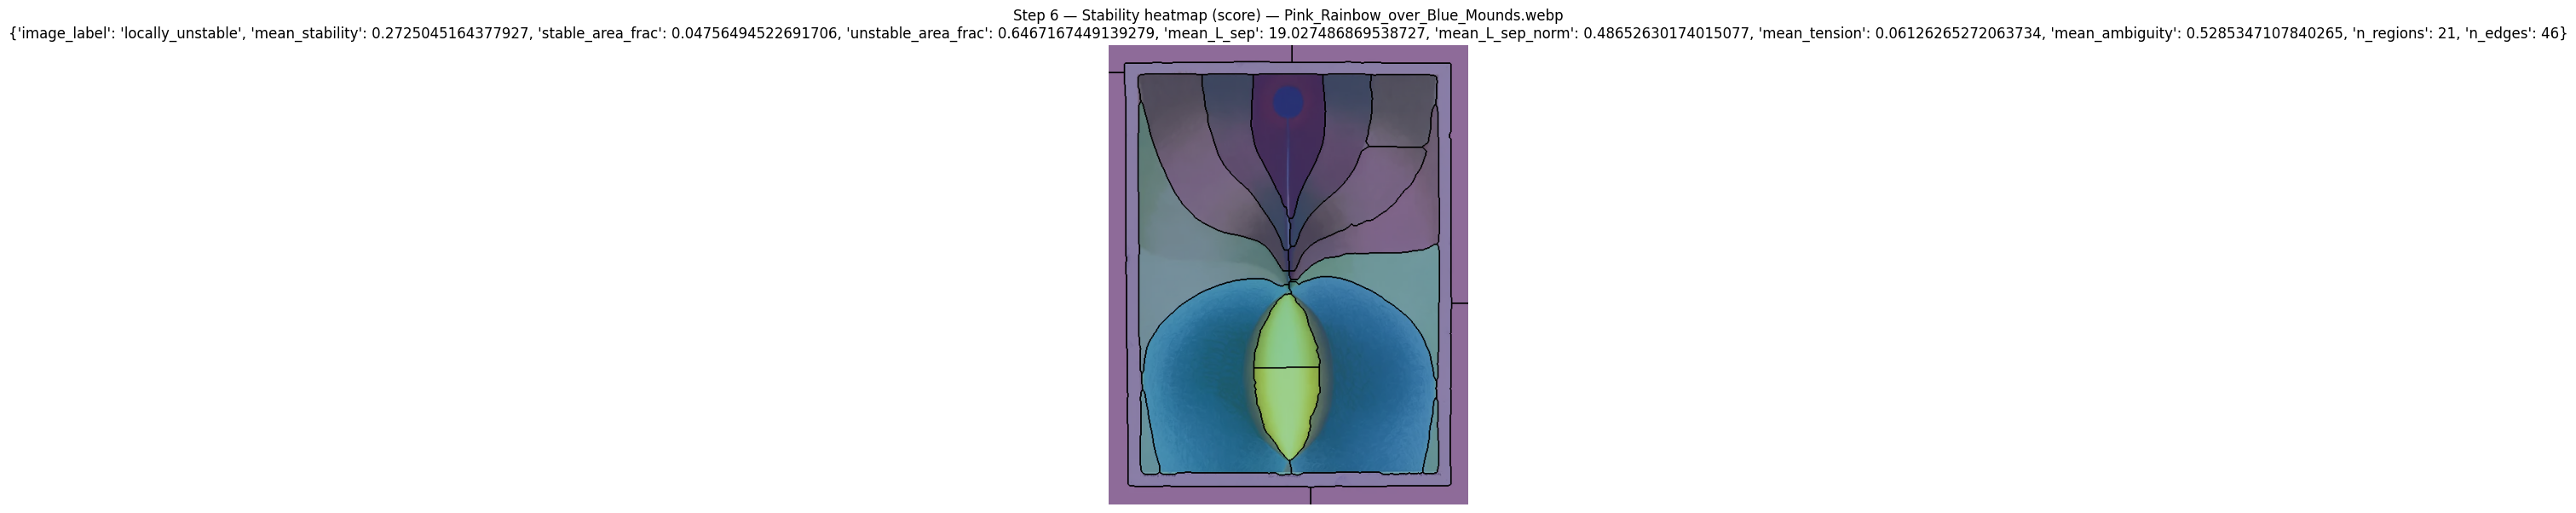

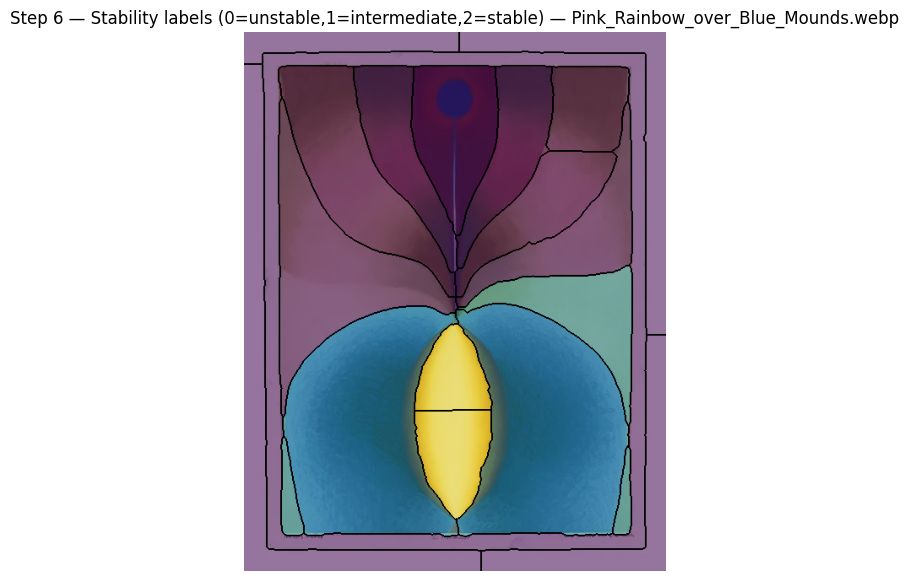

In [38]:
# Pick an image to visualize
idx = 121
path = image_paths[idx]

# Recompute (or reuse) step 6 outputs for this image
dfR6, dfE6, s6 = compute_color_field_stability_for_image(path, min_region_area_px=800)

rgb = load_rgb(path)
labels = structural_segmentation(rgb, min_region_area_px=800)

K = int(labels.max() + 1)
boundary = make_boundary_mask(labels)

# --- Continuous stability heatmap ---
stab = dfR6.sort_values("region_id")["stability_score"].values.astype(float)
stab_map = labels_to_region_image(labels, stab)

plot_overlay_continuous(
    rgb, stab_map, boundary_mask=boundary,
    alpha=0.55,
    title=f"Step 6 — Stability heatmap (score) — {path.name}\n{dict(s6)}",
    cmap=None,   # use matplotlib default
    vmin=0.0, vmax=1.0
)

# --- Categorical stability labels ---
lab = dfR6.sort_values("region_id")["stability_label"].values.astype(str)
# stable=2, intermediate=1, locally_unstable=0
lab_int = np.zeros(K, dtype=int)
lab_int[lab == "intermediate"] = 1
lab_int[lab == "stable"] = 2
lab_map = labels_to_region_image(labels, lab_int)

plot_overlay_categorical(
    rgb, lab_map, boundary_mask=boundary,
    alpha=0.50,
    title=f"Step 6 — Stability labels (0=unstable,1=intermediate,2=stable) — {path.name}"
)

### TOP tension edges

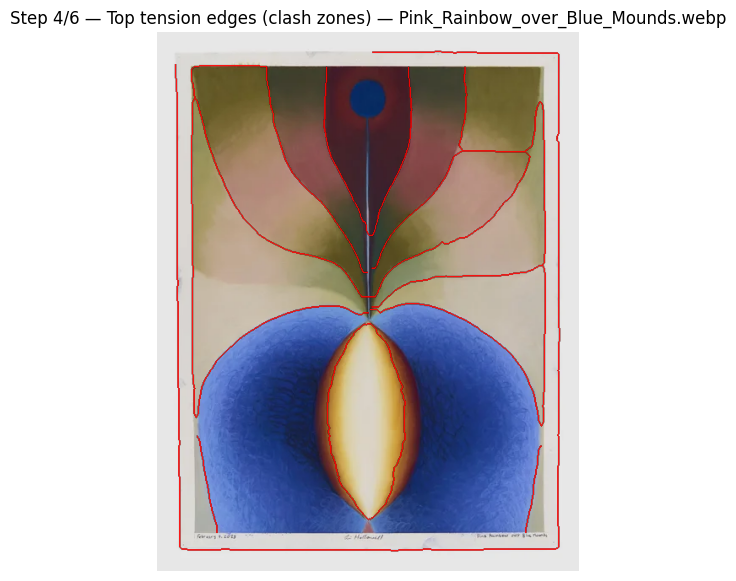

In [39]:
def edge_border_pixels(labels: np.ndarray, region_i: int, region_j: int):
    """
    Approximate shared border pixels between region_i and region_j.
    """
    H, W = labels.shape
    mask_i = labels == region_i
    mask_j = labels == region_j

    # boundary pixels around each region
    bi = find_boundaries(mask_i.astype(int), mode="outer")
    bj = find_boundaries(mask_j.astype(int), mode="outer")

    # shared border approximation: where boundary of i touches j OR boundary of j touches i
    shared = (bi & mask_j) | (bj & mask_i)
    return shared

def plot_top_tension_edges(rgb, labels, df_edges, top_k=20, min_score=None, title=""):
    """
    Draw top tension edges as colored marks on the image.
    No manual annotations.
    """
    # sort by tension_score
    d = df_edges.copy()
    d = d.dropna(subset=["tension_score"])
    d = d.sort_values("tension_score", ascending=False)

    if min_score is not None:
        d = d[d["tension_score"] >= float(min_score)]

    d = d.head(top_k)
    overlay = np.zeros((*labels.shape, 4), dtype=float)

    # paint each edge border in opaque red-ish (one fixed color is fine for "highlight")
    # (This is purely visualization; doesn't affect metrics)
    for _, row in d.iterrows():
        ri = int(row["region_i"])
        rj = int(row["region_j"])
        shared = edge_border_pixels(labels, ri, rj)
        overlay[shared] = [1, 0, 0, 1]  # red highlight

    plt.figure(figsize=(10, 7))
    plt.imshow(rgb)
    plt.imshow(overlay, alpha=0.9)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Use dfE6 (already has tension_score) or recompute via Step 4
plot_top_tension_edges(
    rgb, labels, dfE6,
    top_k=25,
    title=f"Step 4/6 — Top tension edges (clash zones) — {path.name}"
)

In [40]:
from pathlib import Path

viz_dir = Path("outputs_color/overlays_step6")
viz_dir.mkdir(parents=True, exist_ok=True)

def save_overlay_fig(figpath):
    plt.savefig(figpath, dpi=160, bbox_inches="tight", pad_inches=0.05)
    plt.close()

for p in image_paths:
    try:
        dfR6, dfE6, s6 = compute_color_field_stability_for_image(p, min_region_area_px=800)
        rgb = load_rgb(p)
        labels = structural_segmentation(rgb, min_region_area_px=800)
        boundary = make_boundary_mask(labels)
        K = int(labels.max() + 1)

        # stability score map
        stab = dfR6.sort_values("region_id")["stability_score"].values.astype(float)
        stab_map = labels_to_region_image(labels, stab)

        plt.figure(figsize=(10, 7))
        plt.imshow(rgb)
        plt.imshow(stab_map, alpha=0.55, vmin=0.0, vmax=1.0)
        b = np.zeros((*boundary.shape, 4), dtype=float)
        b[boundary] = [0, 0, 0, 1]
        plt.imshow(b)
        plt.title(f"Stability heatmap — {p.name}\n{dict(s6)}")
        plt.axis("off")
        save_overlay_fig(viz_dir / f"{p.stem}__stability_score.png")

        # stability label map
        lab = dfR6.sort_values("region_id")["stability_label"].values.astype(str)
        lab_int = np.zeros(K, dtype=int)
        lab_int[lab == "intermediate"] = 1
        lab_int[lab == "stable"] = 2
        lab_map = labels_to_region_image(labels, lab_int)

        plt.figure(figsize=(10, 7))
        plt.imshow(rgb)
        plt.imshow(lab_map, alpha=0.50)
        plt.imshow(b)
        plt.title(f"Stability labels (0/1/2) — {p.name}")
        plt.axis("off")
        save_overlay_fig(viz_dir / f"{p.stem}__stability_labels.png")

        # top tension edges
        d = dfE6.dropna(subset=["tension_score"]).sort_values("tension_score", ascending=False).head(25)
        overlay = np.zeros((*labels.shape, 4), dtype=float)
        for _, row in d.iterrows():
            shared = edge_border_pixels(labels, int(row["region_i"]), int(row["region_j"]))
            overlay[shared] = [1, 0, 0, 1]

        plt.figure(figsize=(10, 7))
        plt.imshow(rgb)
        plt.imshow(overlay, alpha=0.9)
        plt.title(f"Top tension edges — {p.name}")
        plt.axis("off")
        save_overlay_fig(viz_dir / f"{p.stem}__tension_edges.png")

    except Exception as e:
        print(f"[WARN] overlay export failed: {p.name} -> {e}")

print("Saved overlays to:", viz_dir)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges = morphology.binary_closing(edges, se)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20756\1528251340.py:24: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  edges

Saved overlays to: outputs_color\overlays_step6
